# 06 — Per-Rep Form Classification: Baseline vs 3D CNN vs ST-GCN

Binary per-rep form classification (correct vs incorrect) using three approaches:
1. **Logistic Regression** baseline on per-rep angle statistics
2. **3D CNN (R3D-18)** fine-tuned on rep video clips
3. **ST-GCN** on rep skeleton keypoint sequences

All evaluated on the same 5-fold stratified cross-validation splits (split by video, not by rep).

In [1]:
import sys
sys.path.insert(0, "..")

import json
import logging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from src.classification.stgcn import PushUpSTGCN
from src.classification.video_classifier import PushUpVideoClassifier
from src.classification.datasets import PushUpRepSkeletonDataset, PushUpRepVideoDataset
from src.classification.train_classifier import run_rep_kfold_cv
from src.classification.rep_segmenter import segment_all_videos, compute_rep_features

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# Load manifest
with open("../data/processed/keypoints/manifest.json") as f:
    manifest = json.load(f)

# Paths
KEYPOINT_DIR = Path("../data/processed/keypoints/yolo")
VIDEO_DIR = Path("../data/raw/kaggle_pushups")

# ---- Rep segmentation thresholds ----
# Tune these in notebook 05 first, then set them here to match.
DOWN_THRESHOLD = 110.0
UP_THRESHOLD = 145.0
# --------------------------------------

# Device selection
if torch.cuda.is_available():
    device_str = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device_str = "mps"
else:
    device_str = "cpu"
print(f"Using device: {device_str}")
print(f"Thresholds: down={DOWN_THRESHOLD}°, up={UP_THRESHOLD}°")

# Segment all videos into individual reps
rep_segments = segment_all_videos(
    manifest, KEYPOINT_DIR,
    down_threshold=DOWN_THRESHOLD,
    up_threshold=UP_THRESHOLD,
)

# Add video_path for the video dataset
for rep in rep_segments:
    rep["video_path"] = str(VIDEO_DIR / manifest[rep["video_id"]]["original_path"])

# Stats
n_correct = sum(1 for r in rep_segments if r["label"] == 0)
n_incorrect = sum(1 for r in rep_segments if r["label"] == 1)
rep_lengths = [r["end_frame"] - r["start_frame"] + 1 for r in rep_segments]

print(f"\nTotal reps: {len(rep_segments)}")
print(f"  Correct: {n_correct}, Incorrect: {n_incorrect}")
print(f"  Rep length: min={min(rep_lengths)}, max={max(rep_lengths)}, median={np.median(rep_lengths):.0f}")

# Per-video rep count distribution
from collections import Counter
reps_per_video = Counter(r["video_id"] for r in rep_segments)
n_videos_with_reps = len(reps_per_video)
print(f"  Videos with ≥1 rep: {n_videos_with_reps}/{len(manifest)}")
print(f"  Mean reps/video: {len(rep_segments)/n_videos_with_reps:.1f} (among videos with reps)")

# Common CV config
RANDOM_STATE = 42
N_SPLITS = 5

INFO: Segmented 95 reps from 100 videos (min_frames=10)


Using device: mps
Thresholds: down=110.0°, up=145.0°

Total reps: 95
  Correct: 47, Incorrect: 48
  Rep length: min=12, max=170, median=47
  Videos with ≥1 rep: 88/100
  Mean reps/video: 1.1 (among videos with reps)


## Section 1: Baseline — Logistic Regression

Uses 16 per-rep angle statistics (mean/min/max/range for elbow, back, hip, knee angles).

In [2]:
# Compute per-rep features
X_baseline = np.stack([compute_rep_features(r["keypoints"]) for r in rep_segments])
y_baseline = np.array([r["label"] for r in rep_segments])
rep_video_ids = np.array([r["video_id"] for r in rep_segments])

print(f"Feature matrix: {X_baseline.shape}")

# Get unique videos for stratified splitting
unique_vids = []
unique_labels = []
seen = set()
for r in rep_segments:
    if r["video_id"] not in seen:
        unique_vids.append(r["video_id"])
        unique_labels.append(r["label"])
        seen.add(r["video_id"])
unique_vids = np.array(unique_vids)
unique_labels = np.array(unique_labels)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Cross-validated predictions, split by video
baseline_preds = np.full(len(rep_segments), -1)
baseline_fold_accs = []

for fold, (train_vid_idx, val_vid_idx) in enumerate(skf.split(unique_vids, unique_labels)):
    train_vid_set = set(unique_vids[train_vid_idx])
    val_vid_set = set(unique_vids[val_vid_idx])

    train_mask = np.array([v in train_vid_set for v in rep_video_ids])
    val_mask = np.array([v in val_vid_set for v in rep_video_ids])

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ])
    pipeline.fit(X_baseline[train_mask], y_baseline[train_mask])
    preds = pipeline.predict(X_baseline[val_mask])
    baseline_preds[val_mask] = preds

    fold_acc = accuracy_score(y_baseline[val_mask], preds)
    baseline_fold_accs.append(fold_acc)
    print(f"  Fold {fold}: accuracy={fold_acc:.4f} (n_reps={val_mask.sum()})")

baseline_acc = accuracy_score(y_baseline, baseline_preds)
print(f"\nBaseline overall accuracy: {baseline_acc:.4f}")
print(f"Per-fold mean: {np.mean(baseline_fold_accs):.4f} +/- {np.std(baseline_fold_accs):.4f}")
print()
print(classification_report(y_baseline, baseline_preds, target_names=["correct", "incorrect"]))

Feature matrix: (95, 16)
  Fold 0: accuracy=0.8421 (n_reps=19)
  Fold 1: accuracy=0.9444 (n_reps=18)
  Fold 2: accuracy=0.7895 (n_reps=19)
  Fold 3: accuracy=0.8421 (n_reps=19)
  Fold 4: accuracy=0.7000 (n_reps=20)

Baseline overall accuracy: 0.8211
Per-fold mean: 0.8236 +/- 0.0797

              precision    recall  f1-score   support

     correct       0.77      0.91      0.83        47
   incorrect       0.90      0.73      0.80        48

    accuracy                           0.82        95
   macro avg       0.83      0.82      0.82        95
weighted avg       0.83      0.82      0.82        95



## Section 2: 3D CNN (R3D-18)

Pretrained on Kinetics-400, frozen backbone, fine-tune FC layer only (1,026 trainable params). Classifies per-rep video clips.

In [3]:
def make_r3d_model():
    return PushUpVideoClassifier(freeze_backbone=True, num_classes=2)

def make_rep_video_dataset(reps):
    return PushUpRepVideoDataset(reps, n_frames=16)

print("Training R3D-18 with 5-fold stratified CV (split by video)...")
print(f"  Trainable params: {sum(p.numel() for p in make_r3d_model().parameters() if p.requires_grad)}")

r3d_results = run_rep_kfold_cv(
    model_factory=make_r3d_model,
    dataset_factory=make_rep_video_dataset,
    rep_segments=rep_segments,
    n_splits=N_SPLITS,
    n_epochs=30,
    batch_size=8,
    lr=1e-3,
    patience=10,
    device_str=device_str,
    random_state=RANDOM_STATE,
)

r3d_fold_accs = [f["val_accuracy"] for f in r3d_results["fold_results"]]
print(f"\nR3D-18 per-fold accuracies: {[f'{a:.4f}' for a in r3d_fold_accs]}")
print(f"Mean: {np.mean(r3d_fold_accs):.4f} +/- {np.std(r3d_fold_accs):.4f}")

Training R3D-18 with 5-fold stratified CV (split by video)...


INFO: Fold 0: train=76 reps (70 vids), val=19 reps (18 vids)


  Trainable params: 1026


INFO: Fold 0: early stopping at epoch 25 (best_acc=0.7895)
INFO: Fold 0: val_accuracy=0.7895
INFO: Fold 1: train=77 reps (70 vids), val=18 reps (18 vids)
INFO: Fold 1: early stopping at epoch 18 (best_acc=0.8333)
INFO: Fold 1: val_accuracy=0.8333
INFO: Fold 2: train=76 reps (70 vids), val=19 reps (18 vids)
INFO: Fold 2: early stopping at epoch 11 (best_acc=0.8421)
INFO: Fold 2: val_accuracy=0.8421
INFO: Fold 3: train=76 reps (71 vids), val=19 reps (17 vids)
INFO: Fold 3: early stopping at epoch 11 (best_acc=0.8947)
INFO: Fold 3: val_accuracy=0.8947
INFO: Fold 4: train=75 reps (71 vids), val=20 reps (17 vids)
INFO: Fold 4: early stopping at epoch 11 (best_acc=0.7000)
INFO: Fold 4: val_accuracy=0.7000



R3D-18 per-fold accuracies: ['0.7895', '0.8333', '0.8421', '0.8947', '0.7000']
Mean: 0.8119 +/- 0.0652


## Section 3: ST-GCN

Spatial-Temporal Graph Convolutional Network on torso-normalized per-rep skeleton sequences (~245K params).

In [4]:
def make_stgcn_model():
    return PushUpSTGCN(in_channels=2, num_classes=2, dropout=0.2)

def make_rep_skeleton_dataset(reps):
    return PushUpRepSkeletonDataset(reps, max_frames=64, normalize=True)

print("Training ST-GCN with 5-fold stratified CV (split by video)...")
n_params = sum(p.numel() for p in make_stgcn_model().parameters() if p.requires_grad)
print(f"  Trainable params: {n_params:,}")

stgcn_results = run_rep_kfold_cv(
    model_factory=make_stgcn_model,
    dataset_factory=make_rep_skeleton_dataset,
    rep_segments=rep_segments,
    n_splits=N_SPLITS,
    n_epochs=50,
    batch_size=16,
    lr=1e-3,
    patience=15,
    device_str=device_str,
    random_state=RANDOM_STATE,
)

stgcn_fold_accs = [f["val_accuracy"] for f in stgcn_results["fold_results"]]
print(f"\nST-GCN per-fold accuracies: {[f'{a:.4f}' for a in stgcn_fold_accs]}")
print(f"Mean: {np.mean(stgcn_fold_accs):.4f} +/- {np.std(stgcn_fold_accs):.4f}")

INFO: Fold 0: train=76 reps (70 vids), val=19 reps (18 vids)


Training ST-GCN with 5-fold stratified CV (split by video)...
  Trainable params: 244,290


INFO: Fold 0: early stopping at epoch 33 (best_acc=0.7368)
INFO: Fold 0: val_accuracy=0.7368
INFO: Fold 1: train=77 reps (70 vids), val=18 reps (18 vids)
INFO: Fold 1: early stopping at epoch 30 (best_acc=0.8889)
INFO: Fold 1: val_accuracy=0.8889
INFO: Fold 2: train=76 reps (70 vids), val=19 reps (18 vids)
INFO: Fold 2: early stopping at epoch 41 (best_acc=0.9474)
INFO: Fold 2: val_accuracy=0.9474
INFO: Fold 3: train=76 reps (71 vids), val=19 reps (17 vids)
INFO: Fold 3: early stopping at epoch 24 (best_acc=0.8947)
INFO: Fold 3: val_accuracy=0.8947
INFO: Fold 4: train=75 reps (71 vids), val=20 reps (17 vids)
INFO: Fold 4: early stopping at epoch 23 (best_acc=0.9000)
INFO: Fold 4: val_accuracy=0.9000



ST-GCN per-fold accuracies: ['0.7368', '0.8889', '0.9474', '0.8947', '0.9000']
Mean: 0.8736 +/- 0.0714


## Section 4: Comparison

Per-fold accuracy table and bar chart with error bars across all three methods.

Fold  Baseline (LR)   R3D-18   ST-GCN
   0       0.842105 0.789474 0.736842
   1       0.944444 0.833333 0.888889
   2       0.789474 0.842105 0.947368
   3       0.842105 0.894737 0.894737
   4       0.700000 0.700000 0.900000
Mean       0.823626 0.811930 0.873567


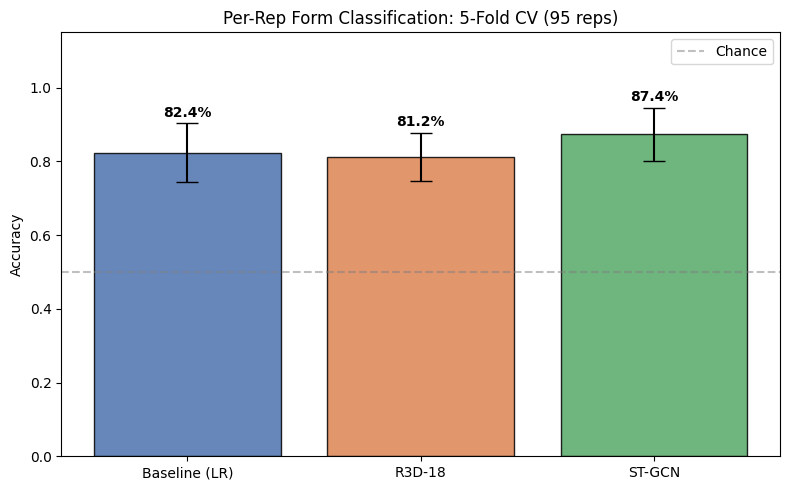

In [5]:
# Per-fold accuracy table
methods = ["Baseline (LR)", "R3D-18", "ST-GCN"]
all_fold_accs = [baseline_fold_accs, r3d_fold_accs, stgcn_fold_accs]
means = [np.mean(a) for a in all_fold_accs]
stds = [np.std(a) for a in all_fold_accs]

comparison_data = {"Fold": list(range(N_SPLITS))}
for name, accs in zip(methods, all_fold_accs):
    comparison_data[name] = accs
df_comparison = pd.DataFrame(comparison_data)

mean_row = pd.DataFrame([{
    "Fold": "Mean",
    **{name: np.mean(accs) for name, accs in zip(methods, all_fold_accs)}
}])
print(pd.concat([df_comparison, mean_row], ignore_index=True).to_string(index=False))

# Bar chart with error bars
colors = ["#4C72B0", "#DD8452", "#55A868"]
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(methods, means, yerr=stds, capsize=8, color=colors, alpha=0.85, edgecolor="black")

for bar, mean, std in zip(bars, means, stds):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + std + 0.01,
            f"{mean:.1%}", ha="center", va="bottom", fontweight="bold")

ax.set_ylabel("Accuracy")
ax.set_title(f"Per-Rep Form Classification: 5-Fold CV ({len(rep_segments)} reps)")
ax.set_ylim(0, 1.15)
ax.axhline(0.5, color="gray", linestyle="--", alpha=0.5, label="Chance")
ax.legend()
plt.tight_layout()
plt.savefig("../outputs/figures/06_accuracy_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

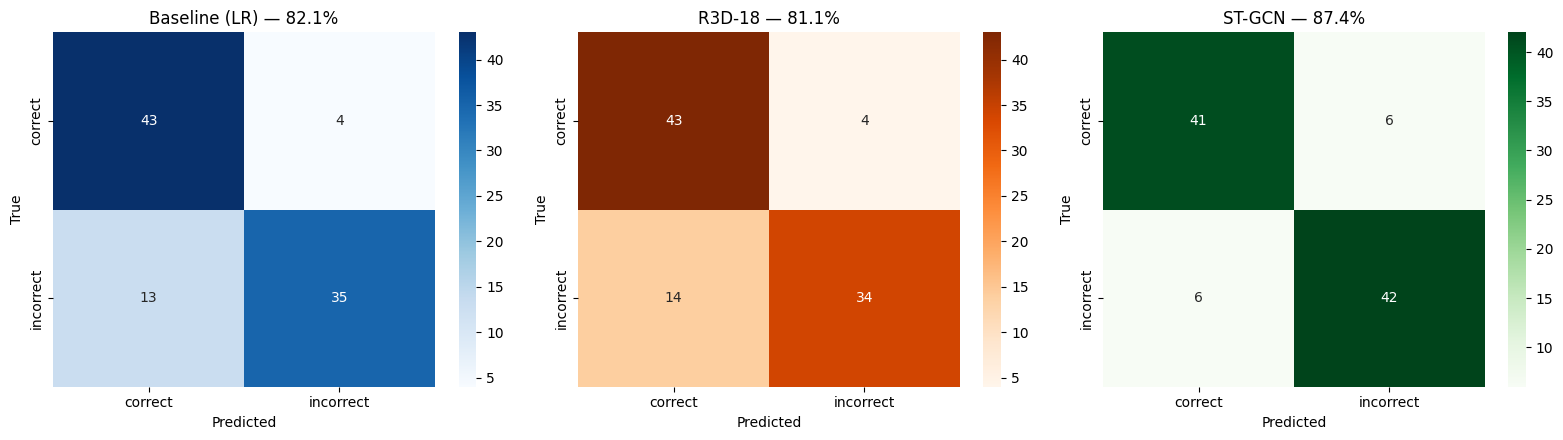

In [6]:
# Confusion matrices side-by-side
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
class_names = ["correct", "incorrect"]

# Baseline
cm_baseline = confusion_matrix(y_baseline, baseline_preds)
sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title(f"Baseline (LR) — {baseline_acc:.1%}")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# R3D-18
r3d_true = r3d_results["per_rep_true"]
r3d_pred = r3d_results["per_rep_preds"]
cm_r3d = confusion_matrix(r3d_true, r3d_pred)
r3d_acc = accuracy_score(r3d_true, r3d_pred)
sns.heatmap(cm_r3d, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title(f"R3D-18 — {r3d_acc:.1%}")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# ST-GCN
stgcn_true = stgcn_results["per_rep_true"]
stgcn_pred = stgcn_results["per_rep_preds"]
cm_stgcn = confusion_matrix(stgcn_true, stgcn_pred)
stgcn_acc = accuracy_score(stgcn_true, stgcn_pred)
sns.heatmap(cm_stgcn, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names, ax=axes[2])
axes[2].set_title(f"ST-GCN — {stgcn_acc:.1%}")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("True")

plt.tight_layout()
plt.savefig("../outputs/figures/06_confusion_matrices.png", dpi=150, bbox_inches="tight")
plt.show()

## Section 5: Error Analysis

Per-rep predictions — identify hard reps and cross-reference with source videos and angle statistics.

In [7]:
# Per-rep prediction summary
results_rows = []
for i, rep in enumerate(rep_segments):
    row = {
        "video_id": rep["video_id"],
        "rep_idx": rep["rep_idx"],
        "true_label": "correct" if rep["label"] == 0 else "incorrect",
        "n_frames": rep["end_frame"] - rep["start_frame"] + 1,
        "baseline_pred": "correct" if baseline_preds[i] == 0 else "incorrect",
        "r3d_pred": "correct" if r3d_pred[i] == 0 else "incorrect",
        "stgcn_pred": "correct" if stgcn_pred[i] == 0 else "incorrect",
    }
    row["baseline_correct"] = row["baseline_pred"] == row["true_label"]
    row["r3d_correct"] = row["r3d_pred"] == row["true_label"]
    row["stgcn_correct"] = row["stgcn_pred"] == row["true_label"]
    row["n_correct_models"] = sum([row["baseline_correct"], row["r3d_correct"], row["stgcn_correct"]])
    results_rows.append(row)

df_results = pd.DataFrame(results_rows)

# Hard reps: misclassified by >= 2 methods
hard_reps = df_results[df_results["n_correct_models"] <= 1]
print(f"Hard reps (misclassified by >= 2 methods): {len(hard_reps)} / {len(rep_segments)}")
if len(hard_reps) > 0:
    print(hard_reps[["video_id", "rep_idx", "true_label", "n_frames",
                      "baseline_pred", "r3d_pred", "stgcn_pred"]].to_string(index=False))

# Per-video agreement
video_summary = df_results.groupby("video_id").agg(
    n_reps=("rep_idx", "count"),
    baseline_acc=("baseline_correct", "mean"),
    r3d_acc=("r3d_correct", "mean"),
    stgcn_acc=("stgcn_correct", "mean"),
).reset_index()

print(f"\nPer-video stats: {len(video_summary)} videos with reps")
print(f"  Mean reps/video: {video_summary['n_reps'].mean():.1f}")

# All 3 methods correct
all_agree = (df_results["n_correct_models"] == 3).sum()
two_agree = (df_results["n_correct_models"] >= 2).sum()
print(f"\nAll 3 methods correct: {all_agree}/{len(rep_segments)} ({all_agree/len(rep_segments):.1%})")
print(f"Majority (>= 2) correct: {two_agree}/{len(rep_segments)} ({two_agree/len(rep_segments):.1%})")

Hard reps (misclassified by >= 2 methods): 13 / 95
                      video_id  rep_idx true_label  n_frames baseline_pred  r3d_pred stgcn_pred
  correct__Copy_of_push_up_127        0    correct        42       correct incorrect  incorrect
  correct__Copy_of_push_up_129        0    correct        45       correct incorrect  incorrect
  correct__Copy_of_push_up_142        0    correct        88     incorrect   correct  incorrect
                 incorrect__10        1  incorrect        15       correct incorrect    correct
                  incorrect__9        0  incorrect        49       correct incorrect    correct
incorrect__Copy_of_push_up_104        0  incorrect       100       correct   correct  incorrect
incorrect__Copy_of_push_up_105        0  incorrect        77       correct   correct  incorrect
incorrect__Copy_of_push_up_198        0  incorrect       170     incorrect   correct    correct
 incorrect__Copy_of_push_up_36        0  incorrect        48       correct   correct 

## Section 6: Save Results

In [8]:
# Save results
RESULTS_DIR = Path("../outputs/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR = Path("../outputs/figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Save per-rep results
df_results.to_csv(RESULTS_DIR / "form_classification_results.csv", index=False)
print(f"Saved: {RESULTS_DIR / 'form_classification_results.csv'} ({len(df_results)} reps)")

# Save comparison summary
summary = pd.DataFrame({
    "Method": methods,
    "Mean_Accuracy": means,
    "Std_Accuracy": stds,
    "Per_Fold": [str(a) for a in all_fold_accs],
})
summary.to_csv(RESULTS_DIR / "form_classification_summary.csv", index=False)
print(f"Saved: {RESULTS_DIR / 'form_classification_summary.csv'}")

# Save best ST-GCN model
if stgcn_results["best_state"] is not None:
    torch.save(stgcn_results["best_state"], MODEL_DIR / "stgcn_best.pt")
    print(f"Saved best ST-GCN model: {MODEL_DIR / 'stgcn_best.pt'}")

print(f"\n=== Summary ({len(rep_segments)} reps from {len(video_summary)} videos) ===")
for method, acc, std in zip(methods, means, stds):
    print(f"  {method:15s}: {acc:.1%} +/- {std:.1%}")
print(f"\nFigures saved to: {FIGURES_DIR}")

Saved: ../outputs/results/form_classification_results.csv (95 reps)
Saved: ../outputs/results/form_classification_summary.csv
Saved best ST-GCN model: ../models/stgcn_best.pt

=== Summary (95 reps from 88 videos) ===
  Baseline (LR)  : 82.4% +/- 8.0%
  R3D-18         : 81.2% +/- 6.5%
  ST-GCN         : 87.4% +/- 7.1%

Figures saved to: ../outputs/figures
